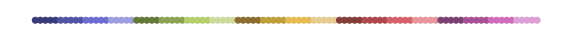

In [4]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from sklearn.linear_model import LinearRegression
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')  # Needed because matplotlib uses idiotic color management.
import sklearn.metrics as skmet
import scipy.stats

from matplotlib import cm

colormap = cm.get_cmap('tab20b')

x = np.linspace(0,1,100)
plt.figure(figsize=(10,.5))
plt.scatter(x, np.zeros(x.shape), c=colormap(x)); plt.axis('off');

In [5]:
plot_info = [(colormap(0), ".", "BIRTH"),
            (colormap(0.61), ".", "RING"),
            (colormap(0.41), ".", "ADULT"),
            (colormap(0.21), ".", "HEART")]

algo_colors={
    "mondrian":colormap(0.1),
    "datafly":colormap(0.3),
    "datafly_shuffled":colormap(0.9)
}

In [6]:
# Collect values of the meta-metric from disk once and for all.

megametric_vs_task = {}
algos = ["mondrian", "datafly", "datafly_shuffled"]

for target in ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]:
    for  col, mark, label in plot_info:
        for algo in algos:
            X_test = pd.read_csv(f"../../{label.lower()}_randoms/metrics_testset.csv")
            X_test = X_test[X_test["algo"] == algo]
            X_test = X_test.drop(["lr_acc", "algo", "no", "auroc", "precision"], axis=1)

            y_test = pd.read_csv(f"../../{label.lower()}_randoms/accuracies_testset.csv")
            y_test = y_test[y_test["algo"] == algo]
            y_test = y_test[target]

            model = pickle.load(open(f"../../autosklearn_models/{label.lower()}_randoms_{target}_{algo}.pkl", "rb"))
            pred_y = model.predict(X_test)

            megametric_vs_task[(target, label, algo)] = (y_test, pred_y)

In [17]:
megametric_vs_task

{('lr_acc', 'BIRTH', 'mondrian'): (2     0.461017
  5     0.515254
  8     0.454237
  11    0.450847
  14    0.477966
  17    0.494915
  20    0.484746
  23    0.423729
  26    0.471186
  29    0.498305
  32    0.454237
  35    0.444068
  38    0.474576
  41    0.423729
  44    0.454237
  47    0.437288
  50    0.454237
  53    0.488136
  56    0.416949
  59    0.467797
  Name: lr_acc, dtype: float64,
  array([0.47630529, 0.47209934, 0.47322326, 0.48158978, 0.46471674,
         0.46619796, 0.47894016, 0.46989209, 0.47605513, 0.47744161,
         0.46951868, 0.44223741, 0.44481445, 0.4504883 , 0.45826673,
         0.46345944, 0.47778259, 0.47149458, 0.4524387 , 0.47114771])),
 ('lr_acc', 'BIRTH', 'datafly'): (0     0.430508
  3     0.433898
  6     0.440678
  9     0.430508
  12    0.430508
  15    0.481356
  18    0.423729
  21    0.430508
  24    0.430508
  27    0.433898
  30    0.427119
  33    0.430508
  36    0.427119
  39    0.430508
  42    0.430508
  45    0.437288
  48    0.45

In [13]:
def niceplot_metric(accuracy, the_label, with_title=False, with_x_label=False, with_y_label=False):
    xmin = 1  # min = biggest possible value to start with
    xmax = 0
    ymin = 1
    ymax = 0
    
    plt.plot([0,1], [0,1], c="black", alpha=.4)  # Put the benchmark
    
    # I'm experimenting with a flipped graph -- let's see how it goes. (x,y) = (y,x)
    for color, mark, label in plot_info:
        
        if label == the_label: # v dirty hack
        
            # Scatter plot of the data.
            for algo in algos:
                y_test, y_pred = megametric_vs_task[(accuracy, label, algo)]
                plt.scatter(y_pred, y_test, c=algo_colors[algo], marker=mark, alpha=1, label=label, s=30)
                
                lin_reg = LinearRegression().fit(y_pred.reshape(-1,1), y_test)
                #print(label, lin_reg.coef_, lin_reg.intercept_)
                margin = 0.1
                x=[[max(0, y_pred.min()-margin)],[min(1, y_pred.max()+margin)]]
                style = ":" if label == "HEART" and algo == "datafly_shuffled"  else "--"
                plt.plot(lin_reg.predict(x), x, linestyle=style, c=algo_colors[algo],linewidth=1, alpha=1)

                # Update the axis size to adjust display region.
                xmin = min(xmin, y_pred.min())
                xmax = max(xmax, y_pred.max())
                ymin = min(ymin, y_test.min())
                ymax = max(ymax, y_test.max())

    # Set a title?
    # no  # plt.title(f"{metric} vs. {accuracy}")
    if with_y_label:
        plt.ylabel(f'{accuracy} (real)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='y', left=False, labelleft=False)
    if with_x_label:
        plt.xlabel(f'(predicted)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='x', bottom=False, labelbottom=False)
    if with_title:
        plt.title(the_label, fontsize=20, fontname='Arial')
    # Round to 0.1.
    xmin = np.floor(xmin*10)/10
    xmax = np.ceil(xmax*10)/10
    ymin = np.floor(ymin*10)/10
    ymax = np.ceil(ymax*10)/10
    plt.ylim([max(0, xmin), min(1, xmax)])
    plt.xlim([max(0, ymin), min(1, ymax)])
    # Set the legend nicely.
    # plt.legend()

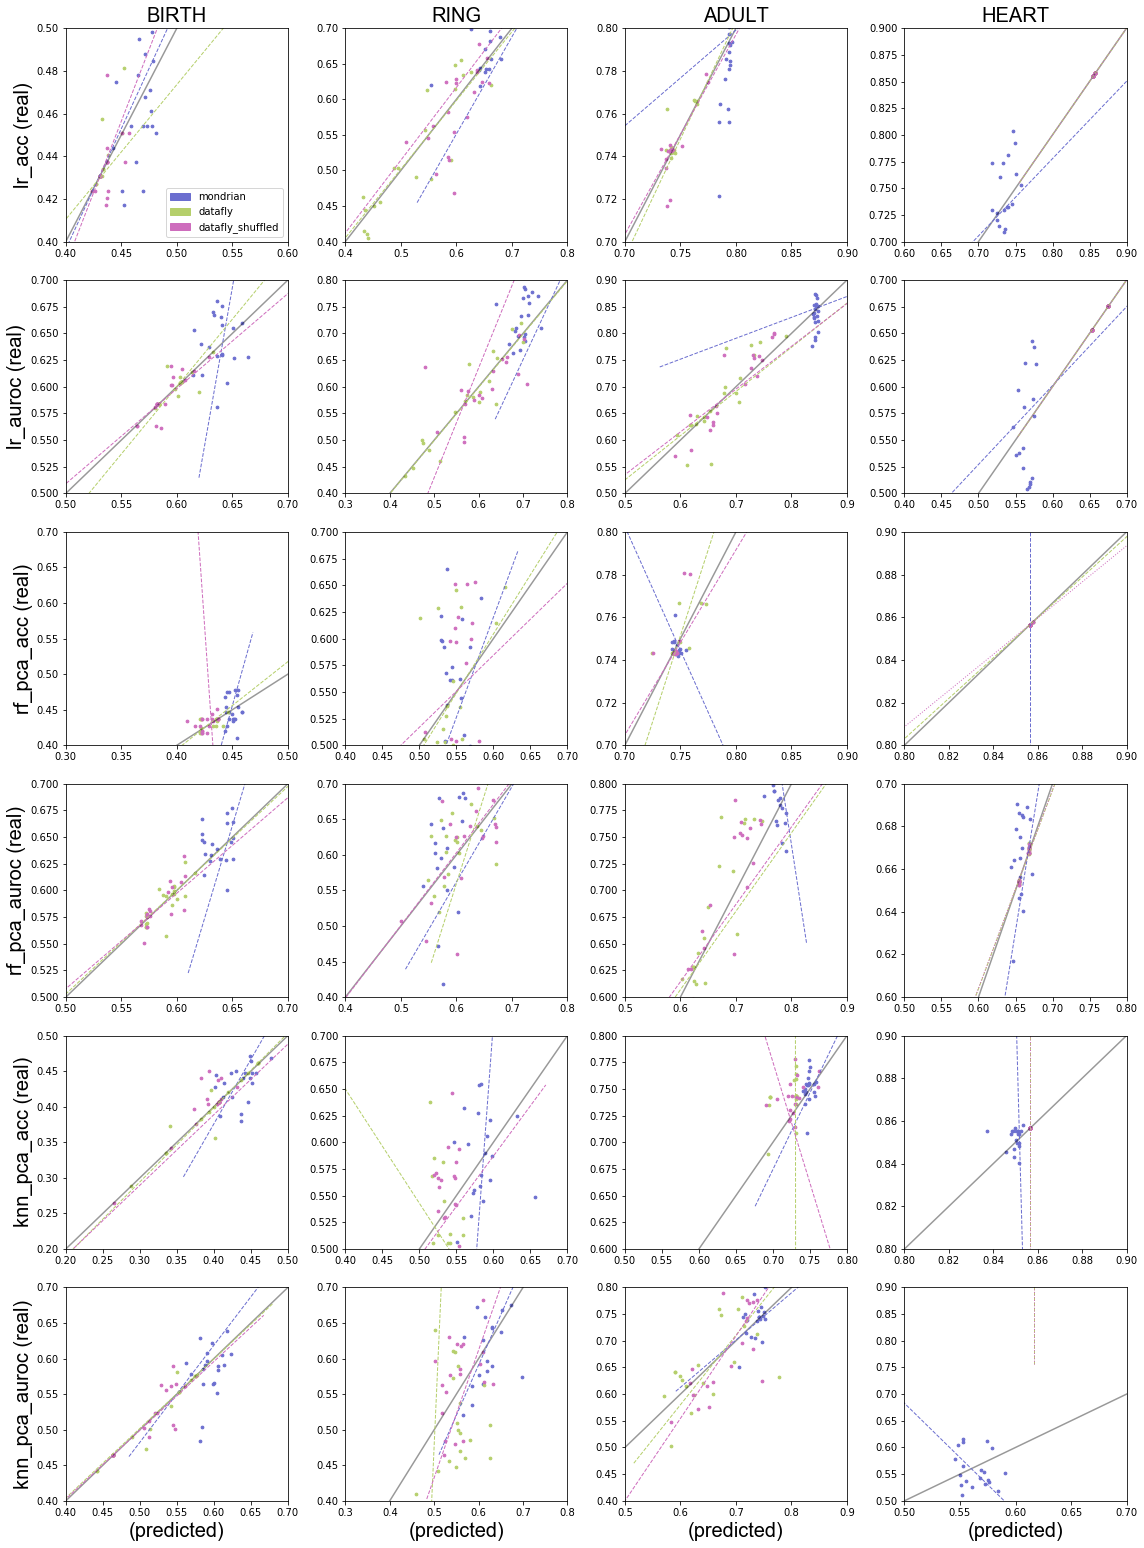

In [15]:
import matplotlib.patches as mpatches

cellsize = 4
n_accs = 6

plt.figure(figsize=(4*cellsize, n_accs*cellsize*0.9))

i = 1
for target in ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]:
    for _,_,label in plot_info:
        plt.subplot(n_accs, 4, i)
        ptches = []
        niceplot_metric(target, label, with_x_label=(i>4*(n_accs-1)), with_y_label=((i%4)==1), with_title=(i<=4))
        for algo in algos:
            p = mpatches.Patch(color=algo_colors[algo], label=algo)
            ptches.append(p)
            
        i += 1
        if label == "BIRTH" and target =="lr_acc":
            plt.legend(handles = ptches)
plt.tight_layout()

plt.savefig('megametrics-vs-accs_sep_trends.png')

# For the other algos

In [90]:
def niceplot_cross_algo(accuracy, the_label, with_title=False, with_x_label=False, with_y_label=False):
    xmin = 1  # min = biggest possible value to start with
    xmax = 0
    ymin = 1
    ymax = 0
    
    plt.plot([0,1], [0,1], c="black", alpha=.4)  # Put the benchmark
    
    # I'm experimenting with a flipped graph -- let's see how it goes. (x,y) = (y,x)
    for color, mark, label in plot_info:
        
        if label == the_label: # v dirty hack
            X_test = pd.read_csv(f"../{label.lower()}_randoms/metrics_testset.csv")
            y = pd.read_csv(f"../{label.lower()}_randoms/accuracies_testset.csv")
            # Scatter plot of the data.
            for algo in algos:
                xs = X_test[X_test["algo"] != algo]
                xs = xs.drop(["lr_acc", "algo", "no", "auroc", "precision"], axis=1)

                y_test = y[y["algo"] != algo]
                y_test = y_test[target]
                
                model = pickle.load(open(f"../autosklearn_models/{label.lower()}_randoms_{accuracy}_{algo}.pkl", "rb"))
                y_pred = model.predict(xs)

                lin_reg = LinearRegression().fit(y_pred.reshape(-1,1), y_test)
                #print(label, lin_reg.coef_, lin_reg.intercept_)
                margin = 0.1
                x=[[max(0, y_pred.min()-margin)],[min(1, y_pred.max()+margin)]]
                style = ":" if label == "HEART" and algo == "datafly_shuffled"  else "--"
                plt.plot(lin_reg.predict(x), x, linestyle=style, c=algo_colors[algo],linewidth=2, alpha=1)

                # Update the axis size to adjust display region.
                xmin = min(xmin, y_pred.min())
                xmax = max(xmax, y_pred.max())
                ymin = min(ymin, y_test.min())
                ymax = max(ymax, y_test.max())

    # Set a title?
    # no  # plt.title(f"{metric} vs. {accuracy}")
    if with_y_label:
        plt.ylabel(f'{accuracy} (real)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='y', left=False, labelleft=False)
    if with_x_label:
        plt.xlabel(f'(predicted)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='x', bottom=False, labelbottom=False)
    if with_title:
        plt.title(the_label, fontsize=20, fontname='Arial')
    # Round to 0.1.
    xmin = np.floor(xmin*10)/10
    xmax = np.ceil(xmax*10)/10
    ymin = np.floor(ymin*10)/10
    ymax = np.ceil(ymax*10)/10
    plt.ylim([max(0, xmin), min(1, xmax)])
    plt.xlim([max(0, ymin), min(1, ymax)])
    # Set the legend nicely.
    # plt.legend()

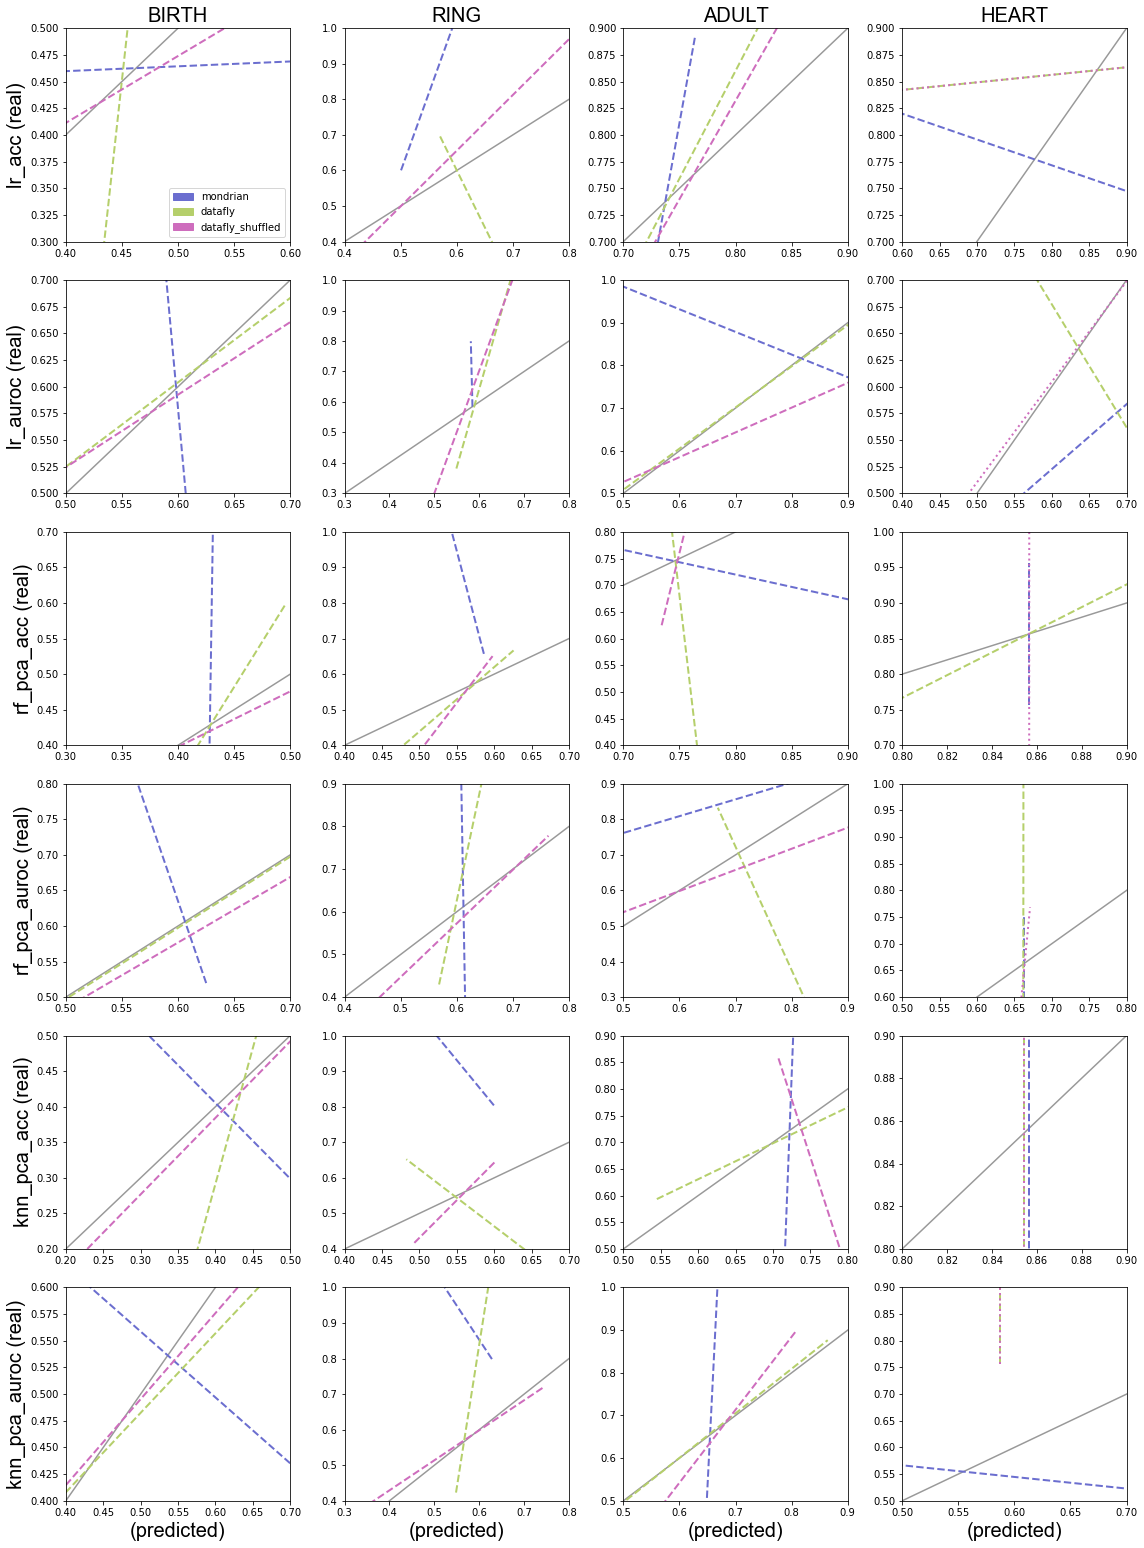

In [91]:
cellsize = 4
n_accs = 6

plt.figure(figsize=(4*cellsize, n_accs*cellsize*0.9))

i = 1
for target in ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]:
    for _,_,label in plot_info:
        plt.subplot(n_accs, 4, i)
        ptches = []
        niceplot_cross_algo(target, label, with_x_label=(i>4*(n_accs-1)), with_y_label=((i%4)==1), with_title=(i<=4))
        for algo in algos:
            p = mpatches.Patch(color=algo_colors[algo], label=algo)
            ptches.append(p)
            
        i += 1
        if label == "BIRTH" and target =="lr_acc":
            plt.legend(handles = ptches)
plt.tight_layout()

plt.savefig('meta_cross_algos.png')

# For the other datasets

In [98]:
def niceplot_cross_sets(accuracy, the_label, with_title=False, with_x_label=False, with_y_label=False):
    xmin = 1  # min = biggest possible value to start with
    xmax = 0
    ymin = 1
    ymax = 0
    
    plt.plot([0,1], [0,1], c="black", alpha=.4)  # Put the benchmark
    
    # I'm experimenting with a flipped graph -- let's see how it goes. (x,y) = (y,x)
    for color, mark, label in plot_info:
        Xs = pd.DataFrame()
        ys = pd.DataFrame()
        
        for l in ["birth", "ring", "adult", "heart"]:
            if l != label.lower():
                Xs = Xs.append(pd.read_csv(f"../{l.lower()}_randoms/metrics_testset.csv"),sort=False)
                ys = ys.append(pd.read_csv(f"../{l.lower()}_randoms/accuracies_testset.csv"),sort=False)
        if label == the_label: # v dirty hack
            # Scatter plot of the data.
            for algo in algos:
                X_test = Xs[Xs["algo"] == algo]
                X_test = X_test.drop(["lr_acc", "algo", "no", "auroc", "precision"], axis=1)

                y_test = ys[ys["algo"] == algo]
                y_test = y_test[target]
                
                model = pickle.load(open(f"../autosklearn_models/{label.lower()}_randoms_{accuracy}_{algo}.pkl", "rb"))
                y_pred = model.predict(X_test)
            
                lin_reg = LinearRegression().fit(y_pred.reshape(-1,1), y_test)
                #print(label, lin_reg.coef_, lin_reg.intercept_)
                margin = 0.1
                x=[[max(0, y_pred.min()-margin)],[min(1, y_pred.max()+margin)]]
                style = ":" if label == "HEART" and algo == "datafly_shuffled"  else "--"
                plt.plot(lin_reg.predict(x), x, linestyle=style, c=algo_colors[algo],linewidth=2, alpha=1)

                # Update the axis size to adjust display region.
                xmin = min(xmin, y_pred.min())
                xmax = max(xmax, y_pred.max())
                ymin = min(ymin, y_test.min())
                ymax = max(ymax, y_test.max())

    # Set a title?
    # no  # plt.title(f"{metric} vs. {accuracy}")
    if with_y_label:
        plt.ylabel(f'{accuracy} (real)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='y', left=False, labelleft=False)
    if with_x_label:
        plt.xlabel(f'(predicted)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='x', bottom=False, labelbottom=False)
    if with_title:
        plt.title(the_label, fontsize=20, fontname='Arial')
    # Round to 0.1.
    xmin = np.floor(xmin*10)/10
    xmax = np.ceil(xmax*10)/10
    ymin = np.floor(ymin*10)/10
    ymax = np.ceil(ymax*10)/10
    plt.ylim([max(0, xmin), min(1, xmax)])
    plt.xlim([max(0, ymin), min(1, ymax)])
    # Set the legend nicely.
    # plt.legend()

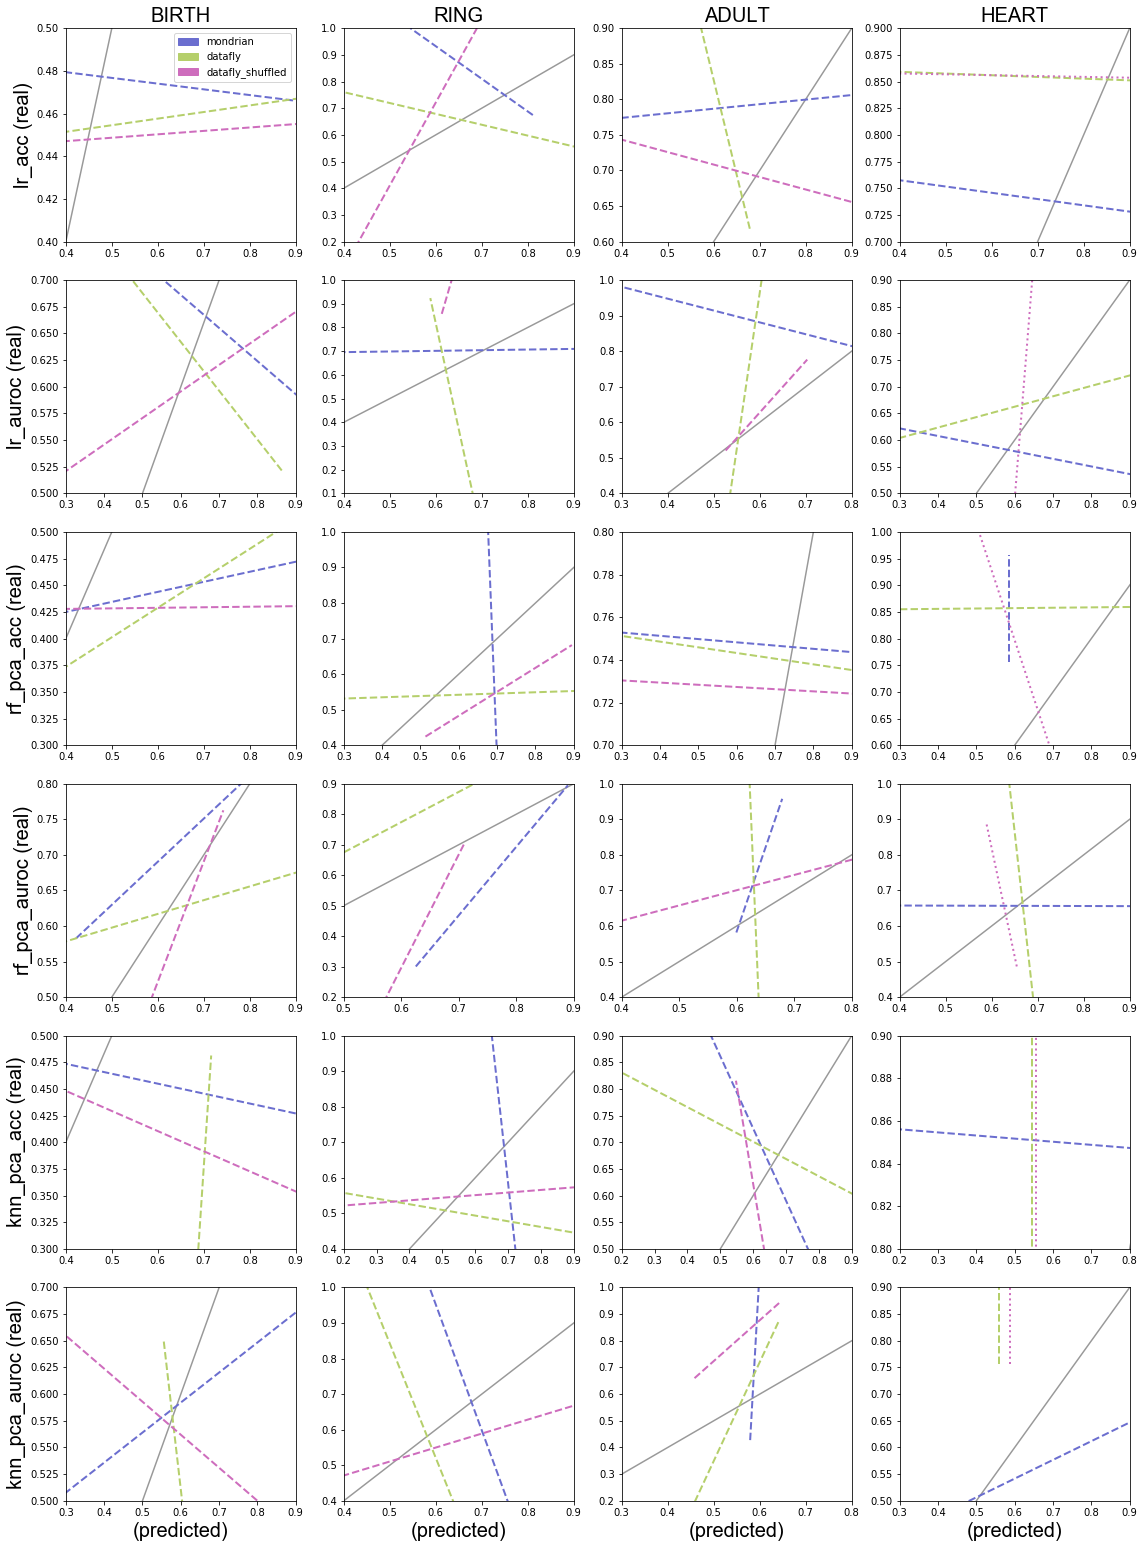

In [99]:
cellsize = 4
n_accs = 6

plt.figure(figsize=(4*cellsize, n_accs*cellsize*0.9))

i = 1
for target in ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]:
    for _,_,label in plot_info:
        plt.subplot(n_accs, 4, i)
        ptches = []
        niceplot_cross_sets(target, label, with_x_label=(i>4*(n_accs-1)), with_y_label=((i%4)==1), with_title=(i<=4))
        for algo in algos:
            p = mpatches.Patch(color=algo_colors[algo], label=algo)
            ptches.append(p)
            
        i += 1
        if label == "BIRTH" and target =="lr_acc":
            plt.legend(handles = ptches)
plt.tight_layout()

plt.savefig('meta_cross_sets.png')

# For the other Measures

In [100]:
def niceplot_cross_measures(accuracy, the_label, with_title=False, with_x_label=False, with_y_label=False):
    xmin = 1  # min = biggest possible value to start with
    xmax = 0
    ymin = 1
    ymax = 0
    
    plt.plot([0,1], [0,1], c="black", alpha=.4)  # Put the benchmark
    
    # I'm experimenting with a flipped graph -- let's see how it goes. (x,y) = (y,x)
    for color, mark, label in plot_info:
        
        if label == the_label: # v dirty hack
            X = pd.read_csv(f"../{label.lower()}_randoms/metrics_testset.csv")
            y = pd.read_csv(f"../{label.lower()}_randoms/accuracies_testset.csv")
            # Scatter plot of the data.
            for algo in algos:
                X_test = X[X["algo"]==algo].drop(["lr_acc", "algo", "no", "auroc", "precision"], axis=1)
                
                for target in ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]:
                    if target != accuracy:
                        y_t = y[y["algo"]==algo][target]
                        model = pickle.load(open(f"../autosklearn_models/{label.lower()}_randoms_{accuracy}_{algo}.pkl", "rb"))
                        y_pred = model.predict(X_test)

                        lin_reg = LinearRegression().fit(y_pred.reshape(-1,1), y_t)
                        #print(label, lin_reg.coef_, lin_reg.intercept_)
                        margin = 0.1
                        x=[[max(0, y_pred.min()-margin)],[min(1, y_pred.max()+margin)]]
                        style = ":" if label == "HEART" and algo == "datafly_shuffled"  else "--"
                        plt.plot(lin_reg.predict(x), x, linestyle=style, c=algo_colors[algo],linewidth=2, alpha=1)

                        # Update the axis size to adjust display region.
                        xmin = min(xmin, y_pred.min())
                        xmax = max(xmax, y_pred.max())
                        ymin = min(ymin, y_test.min())
                        ymax = max(ymax, y_test.max())

    # Set a title?
    # no  # plt.title(f"{metric} vs. {accuracy}")
    if with_y_label:
        plt.ylabel(f'{accuracy} (real)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='y', left=False, labelleft=False)
    if with_x_label:
        plt.xlabel(f'(predicted)', fontsize=20, fontname='Arial')
#     else:
#         plt.tick_params(axis='x', bottom=False, labelbottom=False)
    if with_title:
        plt.title(the_label, fontsize=20, fontname='Arial')
    # Round to 0.1.
    xmin = np.floor(xmin*10)/10
    xmax = np.ceil(xmax*10)/10
    ymin = np.floor(ymin*10)/10
    ymax = np.ceil(ymax*10)/10
    plt.ylim([max(0, xmin), min(1, xmax)])
    plt.xlim([max(0, ymin), min(1, ymax)])
    # Set the legend nicely.
    # plt.legend()
    

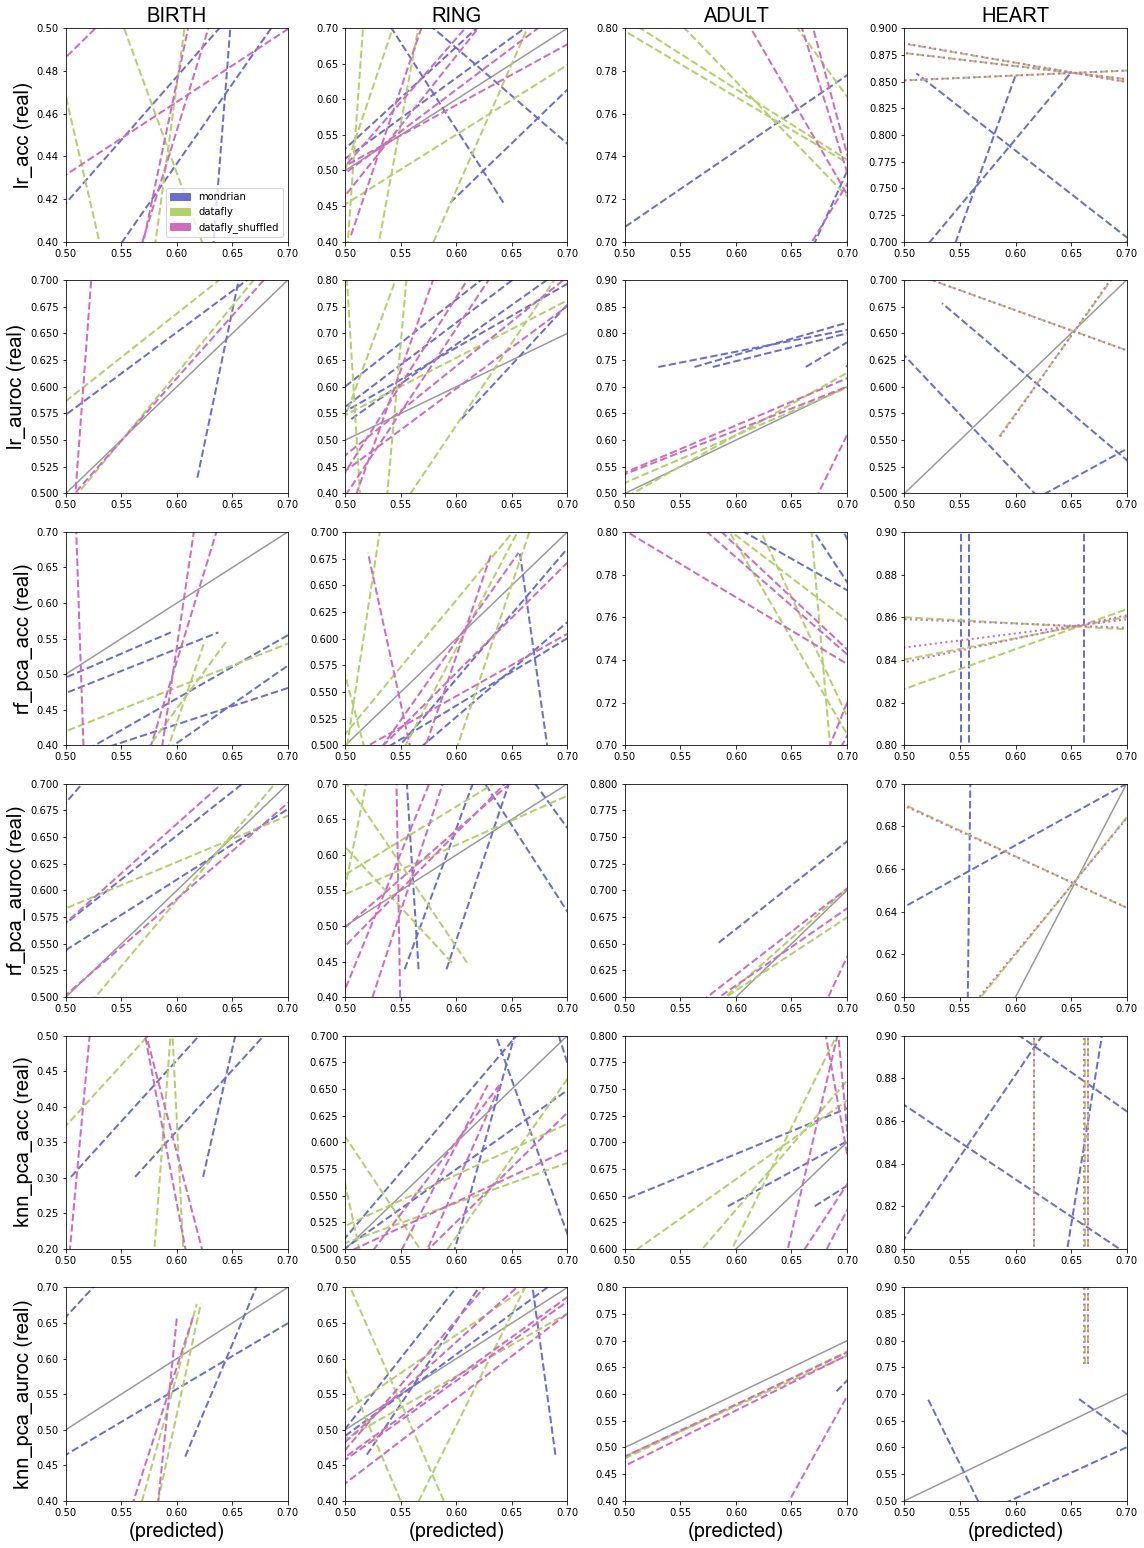

In [101]:
cellsize = 4
n_accs = 6

plt.figure(figsize=(4*cellsize, n_accs*cellsize*0.9))

i = 1
for target in ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]:
    for _,_,label in plot_info:
        plt.subplot(n_accs, 4, i)
        ptches = []
        niceplot_cross_measures(target, label, with_x_label=(i>4*(n_accs-1)), with_y_label=((i%4)==1), with_title=(i<=4))
        for algo in algos:
            p = mpatches.Patch(color=algo_colors[algo], label=algo)
            ptches.append(p)
            
        i += 1
        if label == "BIRTH" and target =="lr_acc":
            plt.legend(handles = ptches)
plt.tight_layout()

plt.savefig('meta_cross_measures.png')